In [2]:
%load_ext autoreload
%autoreload 2

from computage.deage.kdm import KlemeraDoubalEstimator
from computage.deage.pls import PLS1
from computage.utils.data_utils import test_dataset
from computage.utils.metric_utils import print_metrics
import pickle
from sklearn.linear_model import LassoCV, ElasticNetCV

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm

In [3]:
# data, meta = pd.read_pickle(f'/tank/projects/computage/train/GSE51032.pkl.gz', compression='gzip').values()
# data, meta = pd.read_pickle('/tank/projects/computage/train/ultra_train_v1.pkl',).values()
data, meta = pd.read_pickle('/tank/projects/computage/train/ultra_train_v1_cut400k.pkl',).values()

# Prepare new ultra train set

In [ ]:
#other train datasets

train_list = ['GSE40279', 'GSE132203', 'GSE51032', 'GSE41169', 'GSE55763', 
              'GSE64495', 'GSE69270', 'GSE36054', 'GSE87571', 'GSE30870'
              ]
# new_train_list = ['GSE73103']

train_data = pd.DataFrame()
train_meta = pd.DataFrame()

for gse in tqdm(train_list):
    data, meta = pd.read_pickle(f'/tank/projects/computage/train/{gse}.pkl.gz', compression='gzip').values()
    index_intsec = data.index.intersection(meta.index)
    train_data = pd.concat([train_data, data.loc[index_intsec]], axis=0)
    train_meta = pd.concat([train_meta, meta.loc[index_intsec]], axis=0)
    print(gse, train_data.shape[0])

In [ ]:
train_data

In [7]:
train_dataset = {}
train_dataset['data'] = train_data
train_dataset['meta'] = train_meta
# pd.to_pickle(train_dataset, f'/tank/projects/computage/train/ultra_train_v1.pkl.gz', compression='gzip')
pd.to_pickle(train_dataset, f'/tank/projects/computage/train/ultra_train_v1.pkl')

# Prepare dataset to train

In [4]:
# from biolearn.data_library import DataLibrary
# lib = DataLibrary()
# data_source = lib.get('GSE51032')
# data = data_source.load()

In [23]:
# raw_dataset = {}
# raw_dataset['data'] = data.dnam.T.astype('float32')
# raw_dataset['meta'] = data.metadata
# pd.to_pickle(raw_dataset, f'/tank/projects/computage/train/GSE51032.pkl.gz', compression='gzip')

In [9]:
# data, meta = pd.read_pickle('/tank/projects/computage/train/GSE40279.pkl.gz', compression='gzip').values()

In [ ]:
X = data.copy()
y = meta['Age'].copy()

In [ ]:
from biolearn.model_gallery import ModelGallery
gallery = ModelGallery()
list(gallery.model_definitions.keys())
k1 = 'HRSInCHPhenoAge'
k2 = 'PhenoAge'

indices = gallery.get(k1).clock.coefficients.index

In [14]:
# site_sum = data.isna().sum(axis=0)
# s = site_sum / data.shape[0] > 0.8
filt_indices = meta[(meta['Condition'] == 'HC') & (meta['Age'] > 20.0) & (meta['Age'] < 80.0)].index
data_selected = data.loc[filt_indices, indices].dropna(axis=0)
meta_selected = meta.loc[data_selected.index]
y = meta_selected['Age']

In [6]:
# stats.to_csv('/tank/projects/computage/train/train_stats/GSE40279_corrstats.csv')

In [5]:
stats = pd.read_csv('/tank/projects/computage/train/train_stats/ultra_train_v1_corrstats.csv', index_col=0)

In [28]:
stats['fi'] = np.abs(stats['rvalue'])**2 * stats['r_res']
#stats['fi'] = np.abs(stats['rvalue'])**2 * stats['r_res']**2 * np.sign(stats['r_res'])
#stats['fi'] = np.abs(stats['rvalue'])**2 / stats['rse']**2 * stats['r_res']**2
# stats['fi'] = stats['r_res']**2 / stats['rse']**2

stats.sort_values('fi', ascending=False)

,slope,intercept,rvalue,p-value,stderr,rse,r2,s_res,i_res,r_res,p_res,fi
cg14361627,0.002660,0.060500,0.672214,0.000000e+00,0.000047,0.031834,0.451872,0.000410,0.002840,0.216869,9.785804e-42,0.097997
cg10501210,-0.008178,1.090609,-0.715776,0.000000e+00,0.000116,0.091019,0.512336,0.000954,0.022661,0.190656,3.676629e-40,0.097680
cg07955995,0.001269,-0.009066,0.543798,0.000000e+00,0.000028,0.022313,0.295717,0.000327,-0.000647,0.237455,6.672203e-62,0.070219
cg09499629,0.001072,0.039919,0.543108,4.982941e-305,0.000026,0.017856,0.294966,0.000217,0.001721,0.191746,2.380769e-34,0.056559
cg21159778,0.002081,-0.008379,0.483062,1.334247e-276,0.000055,0.042999,0.233349,0.000539,0.005620,0.221920,3.904481e-54,0.051785
...,...,...,...,...,...,...,...,...,...,...,...,...
cg22353329,0.002569,0.096746,0.415620,4.349684e-198,0.000082,0.064129,0.172740,-0.001329,0.115444,-0.359075,9.509110e-145,-0.062026
cg06493994,0.002260,0.095136,0.564402,0.000000e+00,0.000049,0.038159,0.318550,-0.000436,0.051517,-0.206627,2.727849e-45,-0.065821
cg06784991,0.003000,0.096275,0.562930,0.000000e+00,0.000064,0.050247,0.316890,-0.000660,0.070756,-0.224335,2.478728e-55,-0.071089
cg13649056,0.002630,0.082669,0.543301,0.000000e+00,0.000060,0.046908,0.295176,-0.000657,0.069732,-0.255866,2.763550e-69,-0.075525


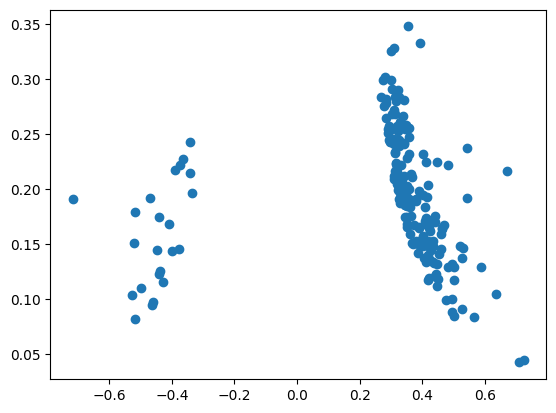

In [29]:
g = stats.sort_values('fi', ascending=False).iloc[:200]

plt.scatter(g['rvalue'], g['r_res'])

In [ ]:
# corrcoefs = X.corrwith(y)

In [35]:
# sorted_sites = corrcoefs.abs().sort_values(ascending=False)
sorted_sites = stats.sort_values('fi', ascending=False)
top_sites = sorted_sites.iloc[:100000].index #sorted_sites[sorted_sites > 0.25].index     #arbitrary threshold !!!

In [36]:
# Xtop = data_selected.copy()
Xtop = data[top_sites].copy().dropna(axis=1)
y = meta.loc[Xtop.index, 'Age']
print(Xtop.shape)

(4758, 17531)


In [ ]:
Xtop = X[indices]

In [ ]:
# from sklearn.model_selection import train_test_split

# X_train, X_test, y_train, y_test = train_test_split(Xtop, y, test_size=0.15)

In [37]:
suff = 'var_20k_pos'

n_components = np.arange(1, 14)
for n in n_components:
    pls = PLS1(n_components=n)
    pls.fit(Xtop, y)
    pickle.dump(pls, open(f'/tank/projects/computage/checkpoints/pls1_{n}_{suff}_ultrav1.pkl', 'wb'))

#PLS with KDM head
n_components = np.arange(1, 14)
for n in n_components:
    pls = PLS1(n_components=n, head_estimator='kdm')
    pls.fit(Xtop, y)
    pickle.dump(pls, open(f'/tank/projects/computage/checkpoints/pls1_{n}_kdm_{suff}_ultrav1.pkl', 'wb'))

In [10]:
#Lasso
lasso = LassoCV(n_alphas=2, n_jobs=8)
lasso.fit(Xtop, y)
pickle.dump(lasso, open(f'/tank/projects/computage/checkpoints/lasso_{suff}_ultrav1.pkl', 'wb'))

/home/dkriukov/.conda/envs/computage/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.584e+04, tolerance: 4.860e+01
  model = cd_fast.enet_coordinate_descent(
/home/dkriukov/.conda/envs/computage/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.173e+04, tolerance: 4.098e+01
  model = cd_fast.enet_coordinate_descent(
/home/dkriukov/.conda/envs/computage/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or

In [ ]:
selection_method = 'forward'
weighings = ['rse', 'r2', 'r2|rse', None]
lasso=True

for w in weighings:
    kdm = KlemeraDoubalEstimator(cv=5, cv_val_size=0.2,
                                feature_selection_method=selection_method,
                                feature_selection_criterion='mse',
                                feature_pval_threshold=0.01,
                                lasso_preselection=lasso,
                                weighing=w,
                                max_features=10000,
                                n_jobs=8,
                                verbose=1)

    kdm.fit(Xtop, y)
    pickle.dump(kdm, open(f'/tank/projects/computage/checkpoints/kdm_{w}_{selection_method}_{str(lasso)}_20k.pkl', 'wb'))

Training estimators on full data.
20263 features remained after applying p-value threshold.
Run Lasso.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
................................................................................................................................................................................................................./home/dkriukov/.conda/envs/computage/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.200e+01, tolerance: 9.259e+00
  model = cd_fast.enet_coordinate_descent(
............................[Parallel(n_jobs=8)]: Done   2 out of   5 | elapsed:  1.4min remaining:  2.1min
......./home/dkriukov/.conda/envs/computage/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check

433 features remained after Lasso pre-selection.
Training estimators on different cv-folds.


100%|██████████| 433/433 [00:17<00:00, 24.08it/s]


Remove redundant features.
6 features remained after selection.
Bvar=36.103
Finished!
Training estimators on full data.
20263 features remained after applying p-value threshold.
Run Lasso.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
......................................................................................................................................................................................................................./home/dkriukov/.conda/envs/computage/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.200e+01, tolerance: 9.259e+00
  model = cd_fast.enet_coordinate_descent(
..........................[Parallel(n_jobs=8)]: Done   2 out of   5 | elapsed:  1.4min remaining:  2.1min
..../home/dkriukov/.conda/envs/computage/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, chec

433 features remained after Lasso pre-selection.
Training estimators on different cv-folds.


KeyboardInterrupt: 

In [ ]:
pickle.dump(kdm, open(f'/tank/projects/computage/checkpoints/kdm_rse_all_20k.pkl', 'wb'))

In [ ]:
kdm

,slope,intercept,rvalue,p-value,stderr,rse,r2,r_abs,fi,adj.p-value,weight
id,,,,,,,,,,,
cg16867657,0.004641,0.372663,0.858536,6.916502e-192,0.000108,0.040879,0.737084,0.858536,513.746823,1.401491e-187,0.040879
cg06639320,0.002811,0.294148,0.747103,4.178307e-118,0.000098,0.036882,0.558162,0.747103,549.222798,4.233252e-114,0.036882
cg24724428,0.003983,0.004570,0.744579,6.716295e-117,0.000140,0.052661,0.554398,0.744579,268.493148,4.536410e-113,0.052661
cg22454769,0.004058,0.334766,0.743994,1.272722e-116,0.000143,0.053747,0.553528,0.743994,257.552502,6.447291e-113,0.053747
cg10501210,-0.007904,1.034369,-0.726036,1.877941e-108,0.000293,0.110406,0.527128,0.726036,59.562840,7.610546e-105,0.110406
...,...,...,...,...,...,...,...,...,...,...,...
cg17338544,-0.000804,0.582865,-0.250025,8.304314e-11,0.000122,0.045908,0.062512,0.250025,118.630900,8.305954e-11,0.045908
cg13308279,-0.001133,0.450821,-0.250016,8.317061e-11,0.000172,0.064687,0.062508,0.250016,59.748853,8.318293e-11,0.064687
cg06518628,0.000378,0.085125,0.250013,8.321555e-11,0.000057,0.021581,0.062507,0.250013,536.819577,8.322376e-11,0.021581


# loading

In [ ]:
pickle.dump(pls, open('/tank/projects/computage/checkpoints/pls1_20000.pkl', 'wb'))

In [ ]:
import pickle

pls = pickle.load(open('/tank/projects/computage/checkpoints/pls1_20000.pkl', 'rb'))

In [ ]:
pls

PLS1(n_components=11)

In [ ]:
import pandas as pd
data, meta = pd.read_pickle('/tank/projects/computage/train/GSE40279.pkl.gz', compression='gzip').values()

In [ ]:
data

id,cg00000029,cg00000108,cg00000109,cg00000165,cg00000236,cg00000289,cg00000292,cg00000321,cg00000363,cg00000622,...,ch.9.945770F,ch.9.96055087R,ch.9.97139671F,ch.9.98463211R,ch.9.98936572R,ch.9.98937537R,ch.9.98957343R,ch.9.98959675F,ch.9.98989607R,ch.9.991104F
GSM989827,0.464197,0.941091,0.911182,0.132014,0.717861,0.686521,0.805003,0.228244,0.338484,0.016508,...,0.022659,0.109918,0.061222,0.034284,0.133693,0.042808,0.052589,0.035624,0.028066,0.043850
GSM989828,0.454883,0.939033,0.596455,0.206917,0.723935,0.619084,0.814672,0.310879,0.418998,0.005747,...,0.005095,0.076996,0.052640,0.027978,0.125270,0.036811,0.053343,0.075618,0.017428,0.032950
GSM989829,0.485764,0.918802,0.870333,0.162861,0.719196,0.635678,0.824336,0.263215,0.424736,0.012197,...,0.021444,0.070694,0.058888,0.032643,0.139105,0.042844,0.045973,0.126421,0.021752,0.022375
GSM989830,0.480785,0.929908,0.889689,0.197780,0.704061,0.610864,0.811152,0.316761,0.398772,0.019945,...,0.028587,0.094749,0.056279,0.036997,0.140601,0.042258,0.048733,0.084051,0.027504,0.053007
GSM989831,0.501220,0.934548,0.890450,0.148437,0.754913,0.651262,0.808628,0.338289,0.366965,0.000000,...,0.018626,0.110543,0.057568,0.036746,0.129993,0.039613,0.039254,0.165874,0.020889,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GSM990623,0.527496,0.958173,0.922034,0.223068,0.778959,0.709248,0.825768,0.354296,0.396241,0.001778,...,0.016319,0.079741,0.072076,0.052052,0.159212,0.049571,0.033060,0.093414,0.013654,0.014088
GSM990624,0.588331,0.982450,0.855145,0.162180,0.796869,0.535832,0.806714,0.295598,0.301319,0.006685,...,0.023837,0.117762,0.058466,0.037199,0.133899,0.055904,0.062442,0.101100,0.014193,0.000000
GSM990625,0.362994,0.954392,0.927184,0.196430,0.713020,0.664184,0.804045,0.395724,0.445179,0.003822,...,0.012054,0.079249,0.053499,0.050002,0.149589,0.048526,0.041087,0.049857,0.016840,0.041415
GSM990626,0.499145,0.931691,0.900938,0.167477,0.730215,0.665792,0.831365,0.338117,0.383953,0.000000,...,0.009878,0.090751,0.060335,0.040898,0.168269,0.056429,0.047835,0.028896,0.025346,0.052959


In [ ]:
pls.predict(data[pls.pls.feature_names_in_])

array([ 66.42367723,  86.84638989,  66.09777852,  65.19766558,
        63.07946109,  79.57633079,  72.89482126,  73.80297895,
        73.52725308,  83.45285966,  81.24766192,  47.34764094,
        77.73492165,  54.23932683,  64.81466742,  70.91454628,
        67.92215057,  79.9651596 ,  89.96608444,  61.09454018,
        79.08460445,  68.22490182,  93.57434465,  83.33718701,
        72.67404202,  74.72274771,  73.25616846,  55.31872063,
        72.36517662,  76.5079233 ,  79.65530652,  73.30333896,
        81.20696417,  73.92909182,  79.9276413 ,  55.85773384,
       100.68049539,  80.01059737,  83.12165139,  86.02318938,
        83.96654195,  76.37917872,  77.30844778,  73.50498884,
        86.77273412,  83.58304909,  87.73991971,  64.28288229,
        78.24121367,  55.79925848,  75.09902065,  66.66558865,
        72.44815166,  56.59411679,  75.94694576,  96.93307961,
        56.76141275,  75.46924962,  46.21147077,  57.7864869 ,
        65.02392686,  84.15695736,  63.02168176,  89.03